<a href="https://colab.research.google.com/github/SHREYA-TK/Dissertation/blob/main/Dissertation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EMOTION DETECTION AND ANALYSIS OF DIFFERENT MENTAL HEALTH CONDITIONS**

Emotions play a critical role in mental health, and understanding emotional expressions can offer deep insights into an individual’s mental state, aiding in early diagnosis. This project aims to develop a model capable of detecting and quantifying emotions in textual data using Machine Learning and Natural Language Processing (NLP).

**Dataset Acquisition and Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Download the GoEmotions dataset
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!pip install scikit-multilearn
!pip install optuna
!pip install datasets


# Import necessary libraries
# General Libraries
import os
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
import wandb
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
# Import the wordcloud library
!pip install wordcloud
from wordcloud import WordCloud
import joblib
from imblearn.over_sampling import RandomOverSampler
import optuna

# Preprocessing and Model Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, make_scorer, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import uniform

# Model-Specific Libraries
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer

# Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SpatialDropout1D
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2024-12-27 23:43:11--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 74.125.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  10.4MB/s    in 1.3s    

2024-12-27 23:43:13 (10.4 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.1 MB/s 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




---



**Exploratory Data Analysis (EDA)**

In [ ]:
# Load the GoEmotions dataset
df = pd.read_csv('data/full_dataset/goemotions_1.csv')
print("Dataset Loaded Successfully")

Dataset Loaded Successfully


*1. Basic Information and Summary*

In [ ]:
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_id  \
0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.548381e+09         1                 False           0  ...     0   
1  1.548084e+09       

In [ ]:
print("\nDataset Shape:")
print(df.shape)


Dataset Shape:
(70000, 37)


In [ ]:
print("\nColumn Information:")
print(df.info())


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  70000 non-null  object 
 1   id                    70000 non-null  object 
 2   author                70000 non-null  object 
 3   subreddit             70000 non-null  object 
 4   link_id               70000 non-null  object 
 5   parent_id             70000 non-null  object 
 6   created_utc           70000 non-null  float64
 7   rater_id              70000 non-null  int64  
 8   example_very_unclear  70000 non-null  bool   
 9   admiration            70000 non-null  int64  
 10  amusement             70000 non-null  int64  
 11  anger                 70000 non-null  int64  
 12  annoyance             70000 non-null  int64  
 13  approval              70000 non-null  int64  
 14  caring                70000 non-null  int64  
 15

In [ ]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int

In [ ]:
print("\nDescriptive Statistics:")
print(df.describe(include='all'))


Descriptive Statistics:
              text       id     author subreddit    link_id  parent_id  \
count        70000    70000      70000     70000      70000      70000   
unique       43182    43358      37803       483      35054      41423   
top     Thank you.  eeqac3k  [deleted]    cringe  t3_ae6ejj  t3_ae6ejj   
freq            14        5       1286       319         35         21   
mean           NaN      NaN        NaN       NaN        NaN        NaN   
std            NaN      NaN        NaN       NaN        NaN        NaN   
min            NaN      NaN        NaN       NaN        NaN        NaN   
25%            NaN      NaN        NaN       NaN        NaN        NaN   
50%            NaN      NaN        NaN       NaN        NaN        NaN   
75%            NaN      NaN        NaN       NaN        NaN        NaN   
max            NaN      NaN        NaN       NaN        NaN        NaN   

         created_utc      rater_id example_very_unclear    admiration  ...  \
count   

*2. Data Preprocessing*

In [ ]:
#2.1  Drop Unnecessary Columns
# List of columns to remove
columns_to_remove = [
    'author',
    'subreddit',
    'link_id',
    'parent_id',
    'created_utc',
    'rater_id',
    'example_very_unclear',
    'neutral'
]
# Drop the columns
df = df.drop(columns=columns_to_remove, axis=1)

# Print the remaining columns to verify
print("Relevant Columns:\n")
print(df.columns)

# 2.2 List of chosen emotions
emotion_columns = ['joy', 'love', 'optimism', 'amusement', 'anger', 'disappointment', 'realization', 'curiousity']
print("\n Chosen Emotions:")
print(emotion_columns)

# 2.3 Define preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply text preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("\nCleaned Text after preprocessing\n\n", df['cleaned_text'])


NameError: name 'df' is not defined

*3. Class Distribution (Target Analysis)*


Class Distribution:
 joy               2607
desire            1248
sadness           2193
anger             2589
surprise          1806
disappointment    2771
love              2745
disgust           1704
confusion         2471
dtype: int64


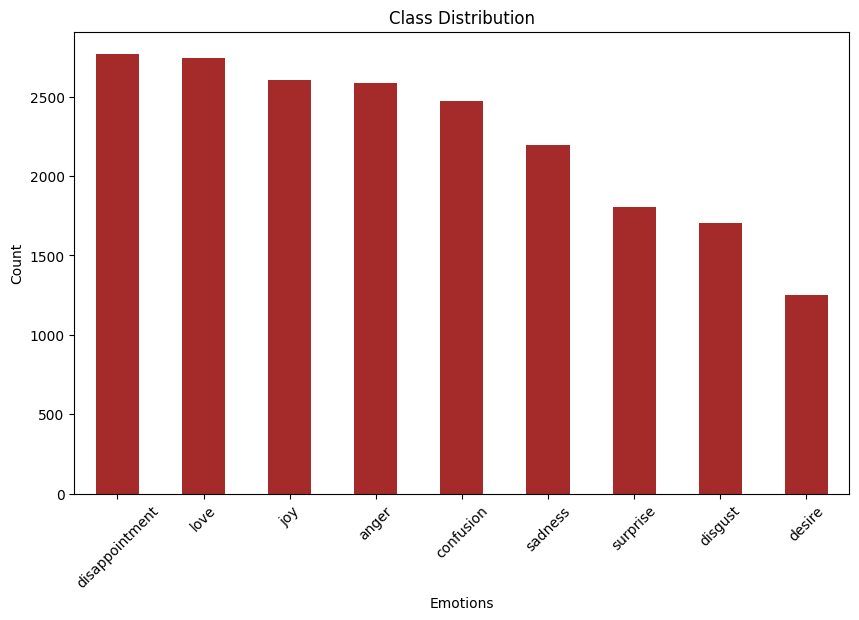

In [ ]:
# Check the class distribution
label_counts = df[emotion_columns].sum()
print("\nClass Distribution:\n", label_counts)

# Visualize Class Distribution
plt.figure(figsize=(10, 6))
label_counts.sort_values(ascending=False).plot(kind='bar', color='brown')
plt.title("Class Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


*3.1    Check for Class Imbalance*

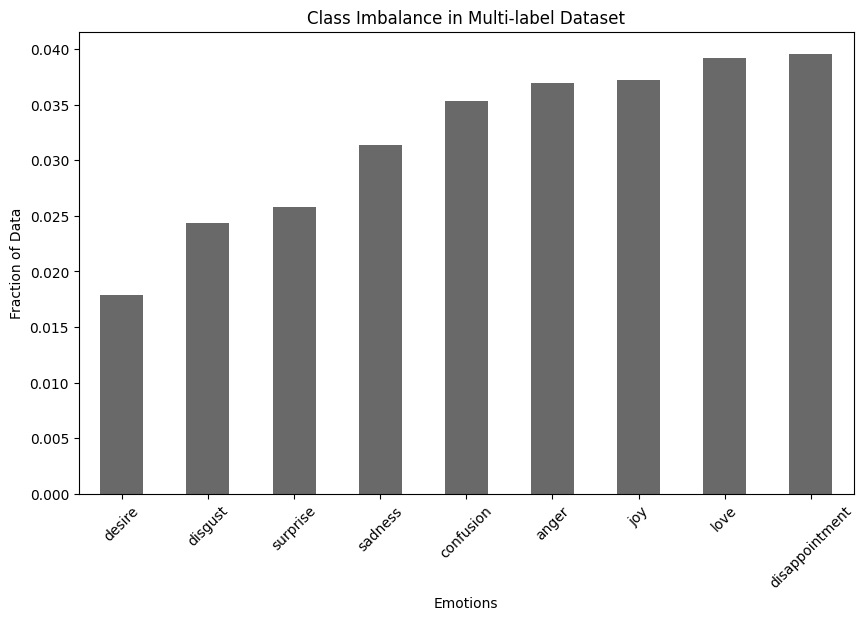

In [ ]:
imbalances = df[emotion_columns].sum()
imbalances = imbalances / df.shape[0]

plt.figure(figsize=(10, 6))
imbalances.sort_values().plot(kind='bar', color='dimgray')
plt.title("Class Imbalance in Multi-label Dataset")
plt.xlabel("Emotions")
plt.ylabel("Fraction of Data")
plt.xticks(rotation=45)
plt.show()

*4. Text Data Insights*

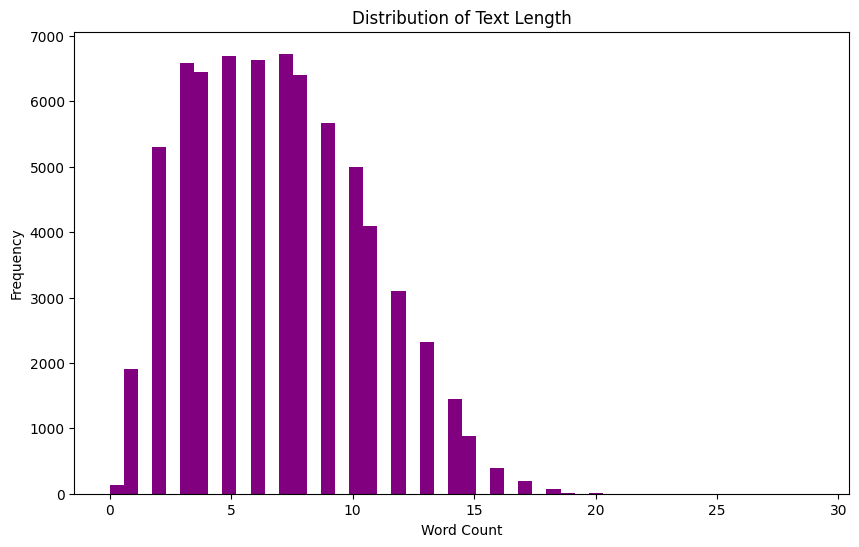

In [ ]:
# Analyze Text Length (number of words in each text)
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

# Text Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='purple')
plt.title("Distribution of Text Length")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

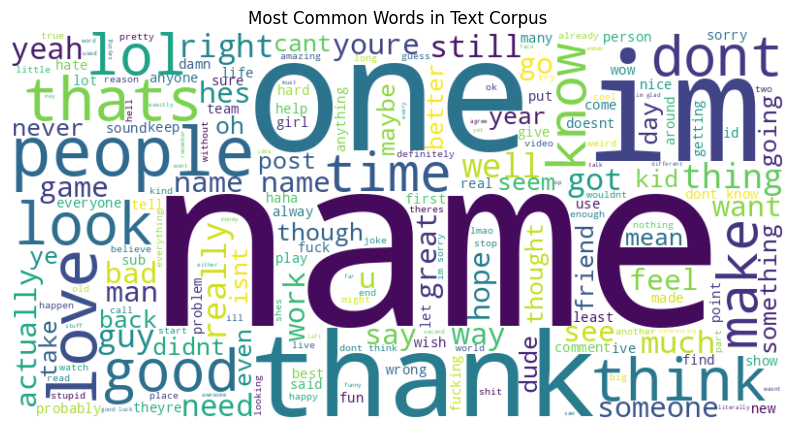

In [ ]:
# Generate WordCloud for the text corpus
text_corpus = " ".join(df['cleaned_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common Words in Text Corpus")
plt.show()


*5. Outlier Detection in Text Length*

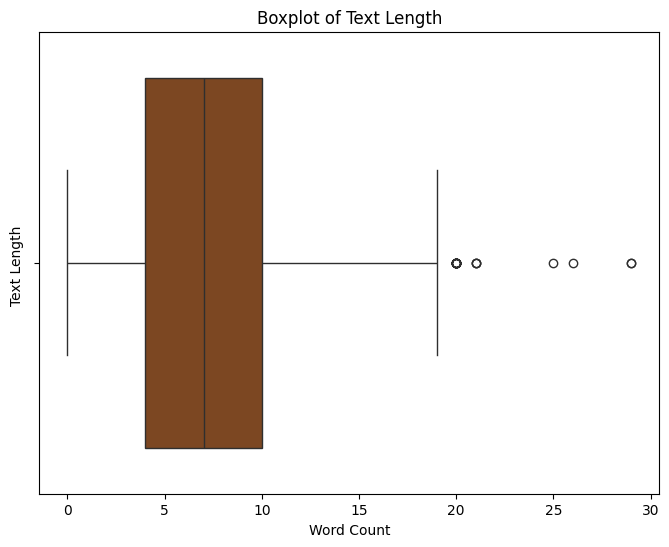

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['text_length'], color='saddlebrown')
plt.title("Boxplot of Text Length")
plt.xlabel("Word Count")
plt.ylabel("Text Length ")
plt.show()

Summary of EDA Observations





In [ ]:
print("\nSummary of EDA Observations:\n")
print("- The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")
print("- The dataset is clean.")
print("- Class distribution shows significant imbalance in some emotion labels.")
print("- Text lengths vary widely, with most texts being short to medium length.")
print("- Key insights on frequent words were visualized using WordCloud.")
print("- Class imbalance needs to be addressed.")

print("\nEDA Completed Successfully!")



Summary of EDA Observations:

- The dataset has 70000 rows and 31 columns.
- The dataset is clean.
- Class distribution shows significant imbalance in some emotion labels.
- Text lengths vary widely, with most texts being short to medium length.
- Key insights on frequent words were visualized using WordCloud.
- Class imbalance needs to be addressed.

EDA Completed Successfully!




---



**Feature  Engineering**

*1. TF-IDF Vectorization*

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])

# Print output details
print(f"TF-IDF Shape: {tfidf_matrix.shape}")
#Inspect Top TF-IDF Features:
feature_names = tfidf.get_feature_names_out()
tfidf_sum = tfidf_matrix.sum(axis=0).A1  # Sum of TF-IDF scores for each feature
sorted_indices = tfidf_sum.argsort()[::-1]
top_features = [(feature_names[i], tfidf_sum[i]) for i in sorted_indices[:20]]
print("Top 20 TF-IDF Features:\n", top_features)


# Save TF-IDF Matrix and Vectorizer as Checkpoints
joblib.dump(tfidf_matrix, '/content/drive/My Drive/tfidf_matrix.pkl')
joblib.dump(tfidf, '/content/drive/My Drive/ tfidf_vectorizer.pkl')
print("TF-IDF Checkpoints Saved Successfully!")

TF-IDF Shape: (70000, 10000)
Top 20 TF-IDF Features:
 [('like', 1135.820990183815), ('im', 985.6316520407038), ('love', 845.7311090693843), ('dont', 828.8045723985421), ('thats', 730.2239740914757), ('good', 674.7060024920467), ('people', 596.3008775235414), ('know', 576.3154414553127), ('thank', 572.1027704467747), ('thanks', 557.4188650472679), ('think', 555.6400569839391), ('really', 553.9145830445406), ('lol', 536.4122469185302), ('oh', 521.604648507928), ('youre', 498.4046028640064), ('time', 496.1122807530902), ('right', 423.7850615304308), ('got', 417.93617075144533), ('didnt', 399.5234191839821), ('way', 382.69363888453853)]
TF-IDF Checkpoints Saved Successfully!


*2.  Splitting the Data*

In [ ]:
# Split the data into train, validation, and test sets

# Define features (X) and labels (Y)
X = tfidf_matrix  # TF-IDF feature matrix
Y = df[emotion_columns].values  # Multi-label targets

# Split into training (70%), temporary (30%)
X_train, Y_train, X_temp, Y_temp = iterative_train_test_split(X, Y, test_size=0.3)

# Split temporary into validation (50%) and test (50%)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_temp, Y_temp, test_size=0.5)

# Save splits as checkpoints
joblib.dump((X_train, Y_train), '/content/drive/My Drive/train_split.pkl' )
joblib.dump((X_val, Y_val), '/content/drive/My Drive/val_split.pkl')
joblib.dump((X_test, Y_test), '/content/drive/My Drive/test_split.pkl')

print("Train, Validation, and Test Splits Saved Successfully!")


Train, Validation, and Test Splits Saved Successfully!


*3. Dimensionality Reduction*

In [ ]:
#Apply Truncated SVD on Each Split

# Number of components to retain
n_components = 300

# Fit SVD on the training set only
print("\nFitting Truncated SVD on the Training Set...")
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_reduced = svd.fit_transform(X_train)

# Apply the fitted SVD to validation and test sets
X_val_reduced = svd.transform(X_val)
X_test_reduced = svd.transform(X_test)

# Save reduced matrices and the SVD model
joblib.dump(X_train_reduced, '/content/drive/My Drive/train_reduced.pkl')
joblib.dump(X_val_reduced, '/content/drive/My Drive/val_reduced.pkl')
joblib.dump(X_test_reduced, '/content/drive/My Drive/test_reduced.pkl')
joblib.dump(svd, '/content/drive/My Drive/svd_model.pkl')

print("Dimensionality Reduction Applied and Checkpoints Saved")


Fitting Truncated SVD on the Training Set...
Dimensionality Reduction Applied and Checkpoints Saved


*4. Handling Class Imbalance using Class Weights*

In [ ]:
# Compute class weights inversely proportional to label frequency
label_sums = Y_train.sum(axis=0)  # Sum occurrences of each label in training data
class_weights = {i: X_train.shape[0] / (len(emotion_columns) * label_sums[i]) for i in range(len(emotion_columns))}

# Display computed class weights
print("\nClass Weights:")
for i, col in enumerate(emotion_columns):
    print(f"{col}: {class_weights[i]}")



Class Weights:
joy: 2.983257229832572
desire: 6.229341469616069
sadness: 3.5468693449149473
anger: 3.0046602894285015
surprise: 4.3073136427566805
disappointment: 2.806414662084765
love: 2.834172016889352
disgust: 4.563658377572879
confusion: 3.147077713551702




---



**Model Training**

The following models are compared based on the performance to choose the best model.


*   Logistic Regression
*   LightGBM
*   BERT





**1. Logistic Regression**

    1.1 Before Optimization

In [ ]:
# Train Logistic Regression with OneVsRestClassifier
print("\nTraining Logistic Regression (Before Optimization)...")
logistic_model_bo = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, class_weight=class_weights)
)
logistic_model_bo.fit(X_train_reduced, Y_train)

# Evaluate on Validation Set
Y_val_pred_bo = logistic_model_bo.predict(X_val_reduced)
Y_val_proba_bo = logistic_model_bo.predict_proba(X_val_reduced)

# Calculate Metrics
accuracy_bo = accuracy_score(Y_val, Y_val_pred_bo)
precision_bo, recall_bo, f1_bo, _ = precision_recall_fscore_support(Y_val, Y_val_pred_bo, average='macro')
auc_pr_bo = roc_auc_score(Y_val, Y_val_proba_bo, average='macro', multi_class='ovr')

# Display Metrics
print("\nPerformance Metrics (Before Optimization):")
print(f"Accuracy: {accuracy_bo * 100:.2f}%")
print(f"Precision (Macro): {precision_bo * 100:.2f}%")
print(f"Recall (Macro): {recall_bo * 100:.2f}%")
print(f"F1-Score (Macro): {f1_bo * 100:.2f}%")
print(f"AUC-PR (Macro): {auc_pr_bo * 100:.2f}%")

# Save the model
joblib.dump(logistic_model_bo, '/content/drive/My Drive/logistic_regression_bo.pkl')
print("Logistic Regression (BO) Model Saved!")

# Save BO metrics
LR_metrics_bo = {
    "accuracy": accuracy_bo,
    "precision": precision_bo,
    "recall": recall_bo,
    "f1_score": f1_bo,
    "auc_pr": auc_pr_bo
}
joblib.dump(LR_metrics_bo, '/content/drive/My Drive/LR_metrics_bo.pkl')
print("BO metrics saved successfully!")





Training Logistic Regression (Before Optimization)...

Performance Metrics (Before Optimization):
Accuracy: 72.45%
Precision (Macro): 38.80%
Recall (Macro): 16.34%
F1-Score (Macro): 21.28%
AUC-PR (Macro): 77.47%
Logistic Regression (BO) Model Saved!
BO metrics saved successfully!


    1.2 After Optimization

In [ ]:
# Logistic Regression wrapped in OneVsRestClassifier
base_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight=class_weights))

# Define Randomized Parameter Grid
param_distributions = {
    'estimator__C': [1, 10, 100, 500, 1000, 5000],  # # Wider range of regularization
    'estimator__solver': ['lbfgs', 'saga', 'newton-cg', 'liblinear']  # Solvers
}

# Randomized Search with 15 iterations
print("\nRunning RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_distributions,
    n_iter=15,  # Number of parameter settings to sample
    cv=3,  # Use 3-fold cross-validation
    scoring='f1_macro',  # Optimize for F1-score (macro)
    n_jobs=-1,
    random_state=42  # For reproducibility
)
random_search.fit(X_train_reduced, Y_train)

# Best Model and Hyperparameters
logistic_model_ao = random_search.best_estimator_
best_params = random_search.best_params_
print("\nBest Hyperparameters Found:")
print(best_params)

# Evaluate Optimized Model on Validation Set
Y_val_pred_ao = logistic_model_ao.predict(X_val_reduced)
Y_val_proba_ao = logistic_model_ao.predict_proba(X_val_reduced)

# Calculate Metrics
accuracy_ao = accuracy_score(Y_val, Y_val_pred_ao)
precision_ao, recall_ao, f1_ao, _ = precision_recall_fscore_support(Y_val, Y_val_pred_ao, average='macro')
auc_pr_ao = roc_auc_score(Y_val, Y_val_proba_ao, average='macro', multi_class='ovr')

# Display Metrics in Percentage
print("\nPerformance Metrics (After Optimization - Randomized Search):")
print(f"Accuracy: {accuracy_ao * 100:.2f}%")
print(f"Precision (Macro): {precision_ao * 100:.2f}%")
print(f"Recall (Macro): {recall_ao * 100:.2f}%")
print(f"F1-Score (Macro): {f1_ao * 100:.2f}%")
print(f"AUC-PR (Macro): {auc_pr_ao * 100:.2f}%")

# Save the Optimized Model
joblib.dump(logistic_model_ao, '/content/drive/My Drive/logistic_regression_ao.pkl')
print("Optimized Logistic Regression Model Saved!")

# Save AO metrics
LR_metrics_ao = {
    "accuracy": accuracy_ao,
    "precision": precision_ao,
    "recall": recall_ao,
    "f1_score": f1_ao,
    "auc_pr": auc_pr_ao
}
joblib.dump(LR_metrics_ao, '/content/drive/My Drive/LR_metrics_ao.pkl')
print("AO metrics saved successfully!")



Running RandomizedSearchCV...

Best Hyperparameters Found:
{'estimator__solver': 'saga', 'estimator__C': 5000}

Performance Metrics (After Optimization - Randomized Search):
Accuracy: 72.26%
Precision (Macro): 50.84%
Recall (Macro): 18.70%
F1-Score (Macro): 23.98%
AUC-PR (Macro): 76.72%
Optimized Logistic Regression Model Saved!
AO metrics saved successfully!


**Comparison of Performance ( Before Vs After Optimization )**

In [ ]:
# Convert Metrics to Percentages
comparison_df1 = pd.DataFrame({
    "Before Optimization": {k: f"{v * 100:.2f}%" for k, v in LR_metrics_bo.items()},
    "After Optimization": {k: f"{v * 100:.2f}%" for k, v in LR_metrics_ao.items()},
})

# Display the Comparison Table
print("\nComparison of Performance Metrics:\n")
print(comparison_df1)

# Save the Table as CSV to Google Drive
comparison_df1.to_csv("/content/drive/My Drive/logistic_regression_comparison.csv", index_label="Metric")
print("\nFile saved to Google Drive!")



Comparison of Performance Metrics:

          Before Optimization After Optimization
accuracy               72.45%             72.26%
precision              38.80%             50.84%
recall                 16.34%             18.70%
f1_score               21.28%             23.98%
auc_pr                 77.47%             76.72%

File saved to Google Drive!


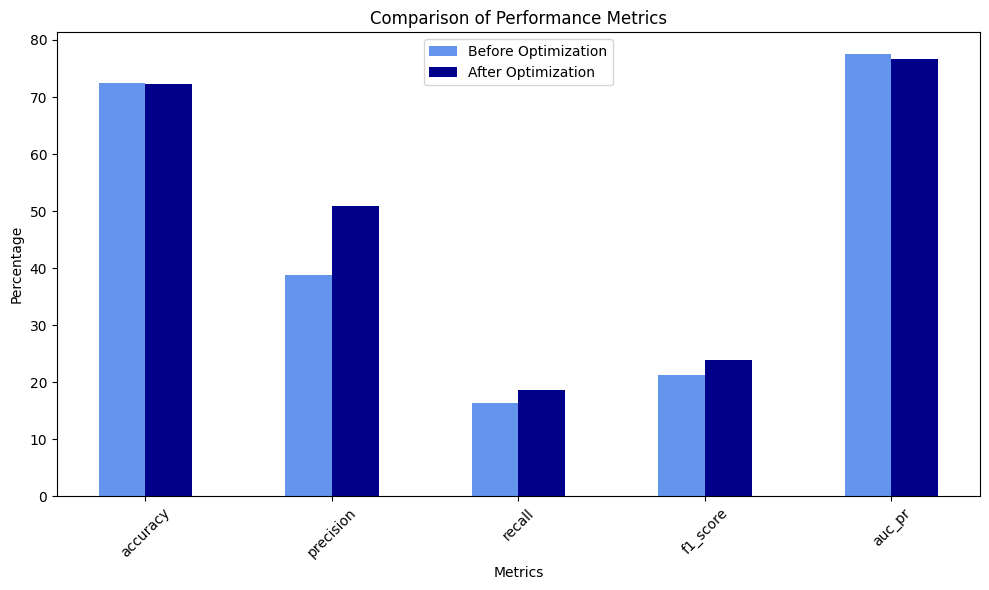

In [ ]:
# Metrics and their values
metrics = comparison_df1.index.tolist()
bo_values = [float(v.strip('%')) for v in comparison_df1['Before Optimization']]
ao_values = [float(v.strip('%')) for v in comparison_df1['After Optimization']]

x = np.arange(len(metrics))  # Metric indices
width = 0.25  # Width of the bars

# Plot grouped bars
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, bo_values, width, label='Before Optimization', color='cornflowerblue')
plt.bar(x + width/2, ao_values, width, label='After Optimization', color='darkblue')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Comparison of Performance Metrics')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


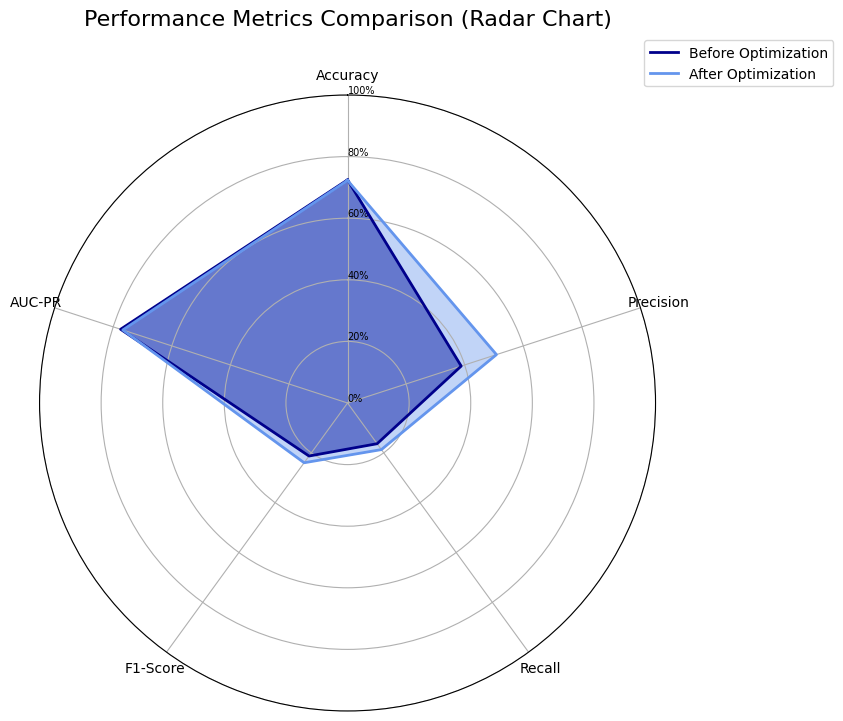

In [ ]:
# Radar chart data
labels = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-PR"]
bo_values = [72.45, 38.80, 16.34, 21.28, 77.47]
ao_values = [72.26, 50.84, 18.70, 23.98, 76.72]

# Ensure circular closure
bo_values.append(bo_values[0])  # Repeat first value at the end
ao_values.append(ao_values[0])  # Repeat first value at the end
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]  # Repeat first angle to close the circle

# Initialize radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks(range(0, 101, 20), ["{}%".format(i) for i in range(0, 101, 20)], color="black", size=7)
plt.ylim(0, 100)

# Plot BO
ax.plot(angles, bo_values, linewidth=2, linestyle='solid', label="Before Optimization", color='darkblue')
ax.fill(angles, bo_values, color='darkblue', alpha=0.6)

# Plot AO
ax.plot(angles, ao_values, linewidth=2, linestyle='solid', label="After Optimization", color='cornflowerblue')
ax.fill(angles, ao_values, color='cornflowerblue', alpha=0.4)

# Add legend and title
plt.title('Performance Metrics Comparison (Radar Chart)', size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()




---



**2. LightGBM**

      2.1 Before Optimization

In [ ]:
# Wrap LightGBM with MultiOutputClassifier
lgb_model_bo = MultiOutputClassifier(
    lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
)

# Train LightGBM (Before Optimization)
print("\nTraining LightGBM (Before Optimization)...")
lgb_model_bo.fit(X_train_reduced, Y_train)

# Evaluate on Validation Set
Y_val_pred_bo = lgb_model_bo.predict(X_val_reduced)
Y_val_proba_bo = np.array([estimator.predict_proba(X_val_reduced)[:, 1] for estimator in lgb_model_bo.estimators_]).T

# Calculate Metrics
accuracy_bo = accuracy_score(Y_val, Y_val_pred_bo)
precision_bo, recall_bo, f1_bo, _ = precision_recall_fscore_support(Y_val, Y_val_pred_bo, average='macro', zero_division=0)
auc_pr_bo = roc_auc_score(Y_val, Y_val_proba_bo, average='macro')

# Display Metrics
print("\nPerformance Metrics (Before Optimization - BO):")
print(f"Accuracy: {accuracy_bo * 100:.2f}%")
print(f"Precision (Macro): {precision_bo * 100:.2f}%")
print(f"Recall (Macro): {recall_bo * 100:.2f}%")
print(f"F1-Score (Macro): {f1_bo * 100:.2f}%")
print(f"AUC-PR (Macro): {auc_pr_bo * 100:.2f}%")

# Save the BO Model
joblib.dump(lgb_model_bo, '/content/drive/My Drive/lightgbm_bo.pkl')
print("LightGBM (BO) Model Saved ")

# Save BO Metrics
LGBM_metrics_bo = {
    "accuracy": accuracy_bo,
    "precision": precision_bo,
    "recall": recall_bo,
    "f1_score": f1_bo,
    "auc_pr": auc_pr_bo
}
joblib.dump(LGBM_metrics_bo, '/content/drive/My Drive/LGBM_metrics_bo.pkl')
print("BO Metrics saved")




Training LightGBM (Before Optimization)...

Performance Metrics (Before Optimization - BO):
Accuracy: 49.47%
Precision (Macro): 22.87%
Recall (Macro): 45.47%
F1-Score (Macro): 30.12%
AUC-PR (Macro): 78.11%
LightGBM (BO) Model Saved 
BO Metrics saved


    2.2 After Optimization

In [ ]:
# Define an objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameter space
    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),  # Optimized range
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),  # Focused to prevent overfitting
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'class_weight': 'balanced',  # Address class imbalance
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }

    # Wrap LightGBM with MultiOutputClassifier
    model = MultiOutputClassifier(lgb.LGBMClassifier(**param))

    # Train the model
    model.fit(X_train_reduced, Y_train)

    # Predict on validation set
    Y_val_pred = model.predict(X_val_reduced)

    # Calculate F1-Score and Recall
    f1 = f1_score(Y_val, Y_val_pred, average='macro', zero_division=0)
    recall = recall_score(Y_val, Y_val_pred, average='macro', zero_division=0)

    # Weighted optimization for F1-Score and Recall
    return f1 + 0.5 * recall

# Perform Bayesian Optimization using Optuna
study = optuna.create_study(direction="maximize")
print("\nOptimizing Hyperparameters for F1-Score and Recall with Optuna...")
study.optimize(objective, n_trials=20)  # 20 trials for better exploration

# Retrieve the best parameters
best_params = study.best_params
print("\nBest Hyperparameters Found:", best_params)

# Train the best model on the entire training set
best_model = MultiOutputClassifier(lgb.LGBMClassifier(**best_params))
best_model.fit(X_train_reduced, Y_train)

# Save the optimized model
joblib.dump(best_model, '/content/drive/My Drive/lightgbm_ao_optimized_f1_recall.pkl')
print("Optimized LightGBM Model Saved!")

# Predict with multiple thresholds
Y_val_proba_ao = np.array([estimator.predict_proba(X_val_reduced)[:, 1] for estimator in best_model.estimators_]).T
thresholds = [0.25, 0.3, 0.35]

# Evaluate for different thresholds
for t in thresholds:
    print(f"\nEvaluating with Threshold: {t}")
    Y_val_pred_adjusted = (Y_val_proba_ao > t).astype(int)

    # Calculate Metrics
    accuracy_ao = accuracy_score(Y_val, Y_val_pred_adjusted)
    precision_ao, recall_ao, f1_ao, _ = precision_recall_fscore_support(Y_val, Y_val_pred_adjusted, average='macro', zero_division=0)
    auc_pr_ao = roc_auc_score(Y_val, Y_val_proba_ao, average='macro')

    print(f"Threshold {t}:")
    print(f"Accuracy: {accuracy_ao * 100:.2f}%")
    print(f"Precision (Macro): {precision_ao * 100:.2f}%")
    print(f"Recall (Macro): {recall_ao * 100:.2f}%")
    print(f"F1-Score (Macro): {f1_ao * 100:.2f}%")
    print(f"AUC-PR (Macro): {auc_pr_ao * 100:.2f}%")

# Save AO Metrics for the best threshold
best_threshold = 0.3
Y_val_pred_best = (Y_val_proba_ao > best_threshold).astype(int)

# Calculate Metrics for the best threshold
accuracy_best = accuracy_score(Y_val, Y_val_pred_best)
precision_best, recall_best, f1_best, _ = precision_recall_fscore_support(Y_val, Y_val_pred_best, average='macro', zero_division=0)
auc_pr_best = roc_auc_score(Y_val, Y_val_proba_ao, average='macro')

# Save the best metrics
LGBM_metrics_ao = {
    "accuracy": accuracy_best,
    "precision": precision_best,
    "recall": recall_best,
    "f1_score": f1_best,
    "auc_pr": auc_pr_best
}
joblib.dump(LGBM_metrics_ao, '/content/drive/My Drive/LGBM_metrics_ao_f1_recall.pkl')
print("\nAO Metrics saved successfully for Threshold:", best_threshold)

# Display Final Metrics
print("\nPerformance Metrics (After Optimization - AO):")
print(f"Accuracy: {accuracy_best * 100:.2f}%")
print(f"Precision (Macro): {precision_best * 100:.2f}%")
print(f"Recall (Macro): {recall_best * 100:.2f}%")
print(f"F1-Score (Macro): {f1_best * 100:.2f}%")
print(f"AUC-PR (Macro): {auc_pr_best * 100:.2f}%")


[I 2024-12-22 04:30:42,237] A new study created in memory with name: no-name-4450d091-b96e-4374-9471-42a84db656b5



Optimizing Hyperparameters for F1-Score and Recall with Optuna...


[I 2024-12-22 04:31:41,192] Trial 0 finished with value: 0.5220793741813515 and parameters: {'num_leaves': 17, 'learning_rate': 0.0345068756305955, 'n_estimators': 253, 'min_child_samples': 32, 'subsample': 0.7206567892651352, 'colsample_bytree': 0.9937201585741471}. Best is trial 0 with value: 0.5220793741813515.
[I 2024-12-22 04:32:14,833] Trial 1 finished with value: 0.5285158161292474 and parameters: {'num_leaves': 17, 'learning_rate': 0.0618158010228325, 'n_estimators': 207, 'min_child_samples': 34, 'subsample': 0.8311423303268061, 'colsample_bytree': 0.6298498955524963}. Best is trial 1 with value: 0.5285158161292474.
[I 2024-12-22 04:33:42,343] Trial 2 finished with value: 0.5067245510073706 and parameters: {'num_leaves': 50, 'learning_rate': 0.046227281143373405, 'n_estimators': 265, 'min_child_samples': 25, 'subsample': 0.9947766776790086, 'colsample_bytree': 0.8149654950415061}. Best is trial 1 with value: 0.5285158161292474.
[I 2024-12-22 04:34:44,477] Trial 3 finished with 


Best Hyperparameters Found: {'num_leaves': 20, 'learning_rate': 0.06184675438129494, 'n_estimators': 221, 'min_child_samples': 45, 'subsample': 0.7728332950378238, 'colsample_bytree': 0.935322430868092}
Optimized LightGBM Model Saved!

Evaluating with Threshold: 0.25
Threshold 0.25:
Accuracy: 69.78%
Precision (Macro): 36.13%
Recall (Macro): 28.01%
F1-Score (Macro): 30.75%
AUC-PR (Macro): 78.27%

Evaluating with Threshold: 0.3
Threshold 0.3:
Accuracy: 71.16%
Precision (Macro): 39.33%
Recall (Macro): 25.70%
F1-Score (Macro): 29.99%
AUC-PR (Macro): 78.27%

Evaluating with Threshold: 0.35
Threshold 0.35:
Accuracy: 71.82%
Precision (Macro): 41.06%
Recall (Macro): 23.01%
F1-Score (Macro): 28.20%
AUC-PR (Macro): 78.27%

AO Metrics saved successfully for Threshold: 0.3

Performance Metrics (After Optimization - AO):
Accuracy: 71.16%
Precision (Macro): 39.33%
Recall (Macro): 25.70%
F1-Score (Macro): 29.99%
AUC-PR (Macro): 78.27%


**Comparison of Performance ( Before Vs After Optimization )**

In [ ]:
# Load the saved BO metrics
LGBM_metrics_bo = joblib.load('/content/drive/My Drive/LGBM_metrics_bo.pkl')
print("Loaded LightGBM BO Metrics:")
for metric, value in LGBM_metrics_bo.items():
    print(f"{metric.capitalize()}: {value * 100:.2f}%")

# Load the saved AO metrics
LGBM_metrics_ao = joblib.load('/content/drive/My Drive/LGBM_metrics_ao_f1_recall.pkl')
print("\nLoaded LightGBM AO Metrics:")
for metric, value in LGBM_metrics_ao.items():
    print(f"{metric.capitalize()}: {value * 100:.2f}%")

# Convert metrics into percentage
comparison_df_lgbm = pd.DataFrame({
    "Before Optimization": {k: f"{v * 100:.2f}%" for k, v in LGBM_metrics_bo.items()},
    "After Optimization": {k: f"{v * 100:.2f}%" for k, v in LGBM_metrics_ao.items()},
})

# Display the Comparison Table
print("\nComparison of LightGBM Performance Metrics:\n")
print(comparison_df_lgbm)

# Save the Table as CSV to Google Drive
comparison_df_lgbm.to_csv("/content/drive/My Drive/lightgbm_comparison.csv", index_label="Metric")
print("\nFile saved to Google Drive!")


Loaded LightGBM BO Metrics:
Accuracy: 49.47%
Precision: 22.87%
Recall: 45.47%
F1_score: 30.12%
Auc_pr: 78.11%

Loaded LightGBM AO Metrics:
Accuracy: 71.16%
Precision: 39.33%
Recall: 25.70%
F1_score: 29.99%
Auc_pr: 78.27%

Comparison of LightGBM Performance Metrics:

          Before Optimization After Optimization
accuracy               49.47%             71.16%
precision              22.87%             39.33%
recall                 45.47%             25.70%
f1_score               30.12%             29.99%
auc_pr                 78.11%             78.27%

File saved to Google Drive!


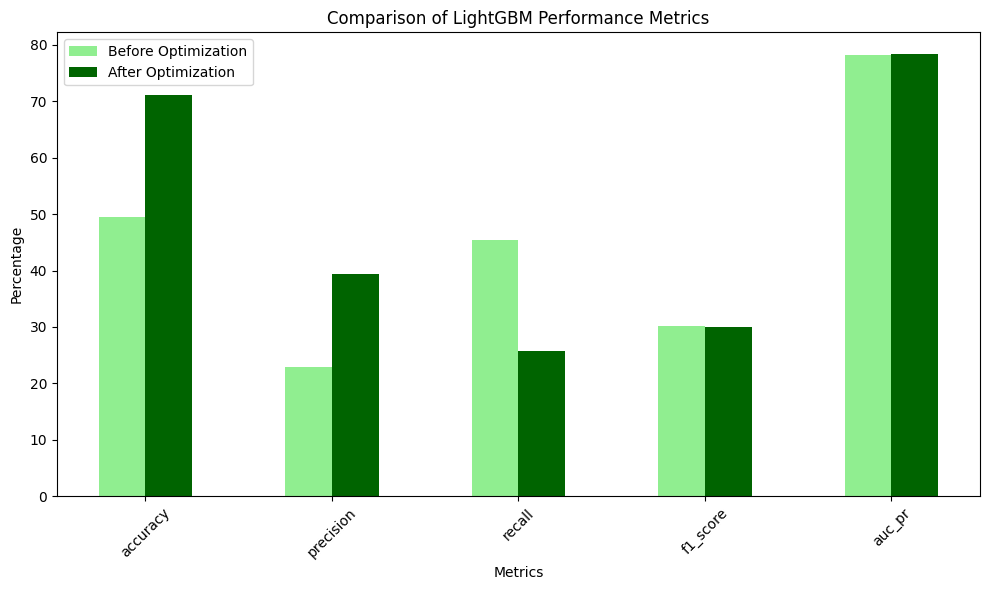

In [ ]:
# Metrics and their values
metrics = comparison_df_lgbm.index.tolist()
bo_values = [float(v.strip('%')) for v in comparison_df_lgbm['Before Optimization']]
ao_values = [float(v.strip('%')) for v in comparison_df_lgbm['After Optimization']]

x = np.arange(len(metrics))  # Metric indices
width = 0.25  # Width of the bars

# Plot grouped bars
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, bo_values, width, label='Before Optimization', color='lightgreen')
plt.bar(x + width/2, ao_values, width, label='After Optimization', color='darkgreen')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Comparison of LightGBM Performance Metrics')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


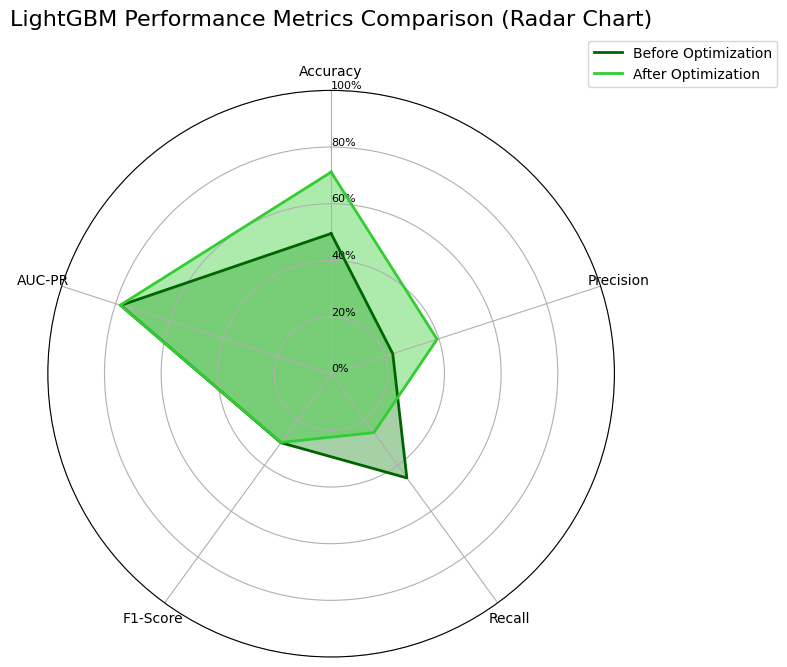

In [ ]:
# Radar chart data for LightGBM
labels = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-PR"]
bo_values = [49.47, 22.87, 45.47, 30.12, 78.11]
ao_values = [71.16, 39.33, 25.70, 29.99, 78.27]

# Ensure circular closure
bo_values.append(bo_values[0])
ao_values.append(ao_values[0])
angles = [n / float(len(labels)) * 2 * math.pi for n in range(len(labels))]
angles += angles[:1]  # Repeat first angle to close the circle

# Initialize radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], labels, fontsize=10, color='black')

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks(range(0, 101, 20), ["{}%".format(i) for i in range(0, 101, 20)], color="black", size=8)
plt.ylim(0, 100)

# Plot BO
ax.plot(angles, bo_values, linewidth=2, linestyle='solid', label="Before Optimization", color='darkgreen')
ax.fill(angles, bo_values, color='forestgreen', alpha=0.4)

# Plot AO
ax.plot(angles, ao_values, linewidth=2, linestyle='solid', label="After Optimization", color='limegreen')
ax.fill(angles, ao_values, color='limegreen', alpha=0.4)

# Add legend and title
plt.title('LightGBM Performance Metrics Comparison (Radar Chart)', size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.tight_layout()

# Show plot
plt.show()




---



**3. DistilBERT**

For Traditional Machine Learning models like Logistic Regression and LightGBM, the input is TF-IDF feature matrix, whereas, for Transformer models like DistilBERT, the input is raw text, which is then converted into token embeddings.

In [ ]:
# Reload labels (Y_train, Y_val, Y_test)
_, Y_train = joblib.load('/content/drive/My Drive/train_split.pkl')
_, Y_val = joblib.load('/content/drive/My Drive/val_split.pkl')
_, Y_test = joblib.load('/content/drive/My Drive/test_split.pkl')

# Split the cleaned_text column directly
x_train = df.iloc[:len(Y_train)]['cleaned_text'].tolist()  # Match the length of Y_train
x_val = df.iloc[len(Y_train):len(Y_train)+len(Y_val)]['cleaned_text'].tolist()
x_test = df.iloc[len(Y_train)+len(Y_val):]['cleaned_text'].tolist()

# Save the text-based splits
joblib.dump((x_train, Y_train), '/content/drive/My Drive/raw_train_split.pkl')
joblib.dump((x_val, Y_val), '/content/drive/My Drive/raw_val_split.pkl')
joblib.dump((x_test, Y_test), '/content/drive/My Drive/raw_test_split.pkl')

print("\nDistilBERT-Compatible Text Splits Saved Successfully!")



DistilBERT-Compatible Text Splits Saved Successfully!


*Verify Types and Sizes of Splits*

In [ ]:
# Check types of splits
print("Checking Types of Splits:")
print(f"Type of X_train (TF-IDF): {type(X_train)}")
print(f"Type of x_train (Raw Text): {type(x_train)}\n")

# Print the size of TF-IDF-based splits
print("Size of TF-IDF-Based Splits:")
print(f"Train Set Size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation Set Size: {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Test Set Size: {X_test.shape[0]} samples, {X_test.shape[1]} features\n")

# Print the size of text-based splits
print("Size of Text-Based Splits:")
print(f"Train Set Size: {len(x_train)} samples")
print(f"Validation Set Size: {len(x_val)} samples")
print(f"Test Set Size: {len(x_test)} samples\n")

# Verify that TF-IDF splits and text splits are different but consistent in size
assert X_train.shape[0] == len(x_train), "Mismatch in Train Set Sizes!"
assert X_val.shape[0] == len(x_val), "Mismatch in Validation Set Sizes!"
assert X_test.shape[0] == len(x_test), "Mismatch in Test Set Sizes!"

print("\nVerification Successful: TF-IDF and Text Splits Are Consistent and Distinct")
print("\n- TF-IDF splits are used for Logistic Regression and LightGBM")
print("\n- Text-based splits will be used for DistilBERT")


Checking Types of Splits:


NameError: name 'X_train' is not defined

3. DistilBERT

    3.1 Before Optimization

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.nn import BCEWithLogitsLoss
import pickle

# Step 1: Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 2: Dataset Class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Step 3: Prepare the Data
train_dataset = Dataset(x_train, Y_train)
val_dataset = Dataset(x_val, Y_val)

# Step 4: Compute Class Weights
class_weights = []
for i in range(Y_train.shape[1]):  # For each label
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=Y_train[:, i]
    )
    class_weights.append(weights[1])  # Use the positive class weight

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define DistilBERT Model with Weighted Loss
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=Y_train.shape[1]
)

class WeightedLoss(torch.nn.Module):
    def __init__(self, pos_weights):
        super(WeightedLoss, self).__init__()
        self.loss_fct = BCEWithLogitsLoss(pos_weight=pos_weights)

    def forward(self, logits, labels):
        return self.loss_fct(logits, labels)

loss_fn = WeightedLoss(pos_weights=class_weights_tensor)
model.loss_fct = loss_fn

# Step 6: Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=6,  # Keep it at 6 for stability
    per_device_train_batch_size=32,  # Updated batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=1e-5,  # Reduced learning rate
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42
)

# Step 7: Custom Metric Function (Micro-Averaging with Debugging)
epoch_metrics = []

def compute_metrics(pred):
    logits, labels = pred
    preds_raw = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (preds_raw > 0.035).astype(int)  # Use threshold of 0.035

    # Debugging Sigmoid Outputs
    print("\nSigmoid Output Range:", preds_raw.min(), preds_raw.max())
    print("Predicted Positive Count Per Label:", preds.sum(axis=0))
    print("Ground Truth Positive Count Per Label:", labels.sum(axis=0))

    # Calculate Metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro", zero_division=0)
    auc_pr = roc_auc_score(labels, preds_raw, average="micro")

    # Save Metrics for Epoch
    epoch_metrics.append({
        "accuracy": accuracy * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
        "auc_pr": auc_pr * 100
    })

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print(f"AUC-PR: {auc_pr * 100:.2f}%")

    return {
        "accuracy": accuracy * 100,  # Convert to percentage
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
        "auc_pr": auc_pr * 100
    }

# Step 8: Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Step 9: Train the Model
print("\nTraining DistilBERT (Before Optimization)...")
trainer.train()

# Save the Metrics of Epoch 6
final_epoch_metrics = epoch_metrics[-1]
metrics_file_path = "/content/drive/My Drive/distilbert_bo_metrics.pkl"
with open(metrics_file_path, "wb") as f:
    pickle.dump(final_epoch_metrics, f)

# Save the Model
trainer.save_model("/content/drive/My Drive/distilbert_bo")
print("DistilBERT BO Model and Metrics Saved to Google Drive.")


    3.2 After Optimization

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import optuna
import pickle

# Step 1: Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 2: Dataset Class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Step 3: Prepare the Data
train_dataset = Dataset(x_train, Y_train)
val_dataset = Dataset(x_val, Y_val)

# Step 4: Compute Class Weights
class_weights = []
for i in range(Y_train.shape[1]):  # For each label
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=Y_train[:, i]
    )
    class_weights.append(weights[1])

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define DistilBERT Model with Weighted Loss
def get_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=Y_train.shape[1]
    )

    class WeightedLoss(torch.nn.Module):
        def __init__(self, pos_weights):
            super(WeightedLoss, self).__init__()
            self.loss_fct = BCEWithLogitsLoss(pos_weight=pos_weights)

        def forward(self, logits, labels):
            return self.loss_fct(logits, labels)

    model.loss_fct = WeightedLoss(pos_weights=class_weights_tensor)
    return model

# Step 6: Objective Function for Optuna
def objective(trial):
    # Hyperparameter Tuning
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    num_epochs = trial.suggest_int('num_epochs', 3, 6)
    threshold = trial.suggest_float('threshold', 0.025, 0.035)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir='./results_distilbert_ao',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=learning_rate,
        logging_dir='./logs',
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=42
    )

    # Custom Metric Function
    def compute_metrics(pred):
        logits, labels = pred
        preds_raw = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (preds_raw > threshold).astype(int)

        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro", zero_division=0)
        auc_pr = roc_auc_score(labels, preds_raw, average="micro")

        return {
            "accuracy": accuracy * 100,
            "precision": precision * 100,
            "recall": recall * 100,
            "f1": f1 * 100,
            "auc_pr": auc_pr * 100
        }

    # Initialize Trainer
    model = get_model()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train and Evaluate
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Step 7: Optimize Hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Step 8: Best Hyperparameters and Final Model
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train with Best Hyperparameters
final_threshold = best_params["threshold"]
training_args = TrainingArguments(
    output_dir='./results_distilbert_ao_final',
    num_train_epochs=best_params["num_epochs"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=best_params["learning_rate"],
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42
)

def final_compute_metrics(pred):
    logits, labels = pred
    preds_raw = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (preds_raw > final_threshold).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro", zero_division=0)
    auc_pr = roc_auc_score(labels, preds_raw, average="micro")

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print(f"AUC-PR: {auc_pr * 100:.2f}%")

    return {
        "accuracy": accuracy * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
        "auc_pr": auc_pr * 100
    }

model = get_model()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=final_compute_metrics
)

# Train and Evaluate Final Model
trainer.train()
final_results = trainer.evaluate()

# Save Model and Metrics
trainer.save_model("/content/drive/My Drive/distilbert_ao")
metrics_file_path = "/content/drive/My Drive/distilbert_ao_metrics.pkl"
with open(metrics_file_path, "wb") as f:
    pickle.dump(final_results, f)

print("DistilBERT AO Model and Metrics Saved to Google Drive.")


[I 2024-12-25 21:43:27,510] A new study created in memory with name: no-name-bfed479c-de66-474e-b44a-d7203e4b87e9
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Pr
1,0.138300,0.141304,0.000000,3.726984,38.874172,6.801854,55.493707
2,0.141800,0.140811,0.000000,3.648510,63.476821,6.900400,55.588051
3,0.150700,0.140704,0.000000,3.725395,65.927152,7.052281,56.236745


[I 2024-12-25 22:05:18,093] Trial 0 finished with value: 7.052281099461603 and parameters: {'learning_rate': 3.131436694324744e-05, 'batch_size': 32, 'num_epochs': 3, 'threshold': 0.030318977755765846}. Best is trial 0 with value: 7.052281099461603.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Pr
1,0.137900,0.140673,0.000000,3.766281,65.397351,7.122379,55.695573
2,0.141800,0.140711,0.000000,3.778392,52.549669,7.049887,55.998328
3,0.150600,0.140648,0.000000,3.818569,51.125828,7.106365,56.303667
4,0.135400,0.140656,0.000000,3.798347,56.158940,7.115437,56.312562


[I 2024-12-25 22:34:23,835] Trial 1 finished with value: 7.122378694170468 and parameters: {'learning_rate': 3.6248335516411665e-06, 'batch_size': 32, 'num_epochs': 4, 'threshold': 0.033526852265751285}. Best is trial 1 with value: 7.122378694170468.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Pr
1,0.166400,0.160761,0.000000,3.195767,100.000000,6.193601,55.545377
2,0.145500,0.142607,0.000000,3.481499,84.834437,6.688509,55.864420
3,0.151400,0.140816,0.000000,3.661905,76.390728,6.988791,56.259977
4,0.136600,0.140659,0.000000,3.669445,75.794702,7.000000,56.284687


[I 2024-12-25 23:03:27,214] Trial 2 finished with value: 7.000000000000001 and parameters: {'learning_rate': 1.098594423866522e-06, 'batch_size': 32, 'num_epochs': 4, 'threshold': 0.032670367449587706}. Best is trial 1 with value: 7.122378694170468.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Pr
1,0.138300,0.141200,0.019048,3.628840,25.264901,6.346170,55.561190
2,0.141400,0.140747,0.000000,3.699029,60.165563,6.969563,55.483126


[W 2024-12-25 23:22:58,360] Trial 3 failed with parameters: {'learning_rate': 1.7937252384541707e-05, 'batch_size': 32, 'num_epochs': 3, 'threshold': 0.032513787329684844} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-22-6f07fbfb2bbd>", line 118, in objective
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2164, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2529, in _inner_training_loop
    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
KeyboardInterrupt
[W 2024-12-25 23:22:58,362] Trial 3 failed with value None.


KeyboardInterrupt: 